In [1]:
import os
import sys 
sys.path.append(os.path.abspath('..'))
sys.path.append(os.path.abspath('../../latent_analysis/'))
import LTransform as LT
from get_utils import get_hidden, get_force
from pathlib import Path
import numpy as np
import torch as th
import plot as plot
import matplotlib.pyplot as plt
from scipy.spatial.distance import pdist, squareform
import pandas as pd
import seaborn as sb
import scipy.stats as stats

#%matplotlib widget
#%matplotlib qt
%matplotlib inline

In [24]:
from tdr import gsog

folder_name = 'Sim_all_inv' 

ff_coef = [0,8,0,8]
phase = {'NF1':[0],'FF1':[8],'NF2':[0],'FF2':[8]}
labels = ['NF1','FF1','NF2','FF2']

T = pd.DataFrame()

N_idx = 10 # index of hidden activity 
F_idx = 24 # index of force

rdms = []
for mn in range(0,20):
    model_name = "model{:02d}".format(mn)
    
    data = get_hidden(folder_name,model_name,phase,ff_coef,demean=False)
    force = get_force(folder_name,model_name,phase,ff_coef)

    for i in range(len(data)):
        data[i] = data[i][:,N_idx,:]
        force[i] = force[i][:,F_idx,:]

    # remove overall mean
    combined_N = np.vstack(data)
    mean_N = np.mean(combined_N, axis=0)
    for i in range(len(data)):
        data[i] = data[i]-mean_N

    # use NF1 to project onto TDR axes
    X = force[0] # NF1 force 
    N = data[0] # NF1 hidden activity

    X = np.hstack((X,np.ones((X.shape[0],1))))
    beta_b2n = np.linalg.pinv(X) @ N

    # Compute the TDR axes.
    beta_n2b = np.linalg.pinv(beta_b2n)
    beta_n2b = beta_n2b[:,:2]

    # Orthogonalize the TDR axes before projection.
    beta_n2b_orth = gsog(beta_n2b)[0]

    # Project before-learning and after-learning neural activity onto the TDR axes
    data_p = data.copy()
    for i in range(len(data)):
        data_p[i] = data_p[i] @ beta_n2b_orth
    
    # RDM
    D = np.stack(data_p)
    dims = D.shape
    D = D.reshape(dims[0],-1)
    rdms.append(pdist(D))


    # uniform shift from NF1 to FF1
    us = np.mean(data[1]-data[0],axis=0)
    us = us.reshape(-1,1)
    us.shape
    us_orth = us - np.dot(beta_n2b_orth[:,0],us)/np.linalg.norm(beta_n2b_orth[:,0])**2 * beta_n2b_orth[:,0][:,None]
    us_orth = us_orth - np.dot(beta_n2b_orth[:,1],us_orth)/np.linalg.norm(beta_n2b_orth[:,1])**2 * beta_n2b_orth[:,1][:,None]

    # np.dot(beta_n2b_orth[:,1],us_orth) # sanity check
    us_orth_norm = us_orth/np.linalg.norm(us_orth)
    
    for i,l in enumerate(labels):
        u = data[i]@us_orth_norm
        u = np.mean(u)

        d = {'mn':[mn],'phase':[l],'us':[u]}
        T = pd.concat([T,pd.DataFrame(d)],ignore_index=True)

# Project on the Force space

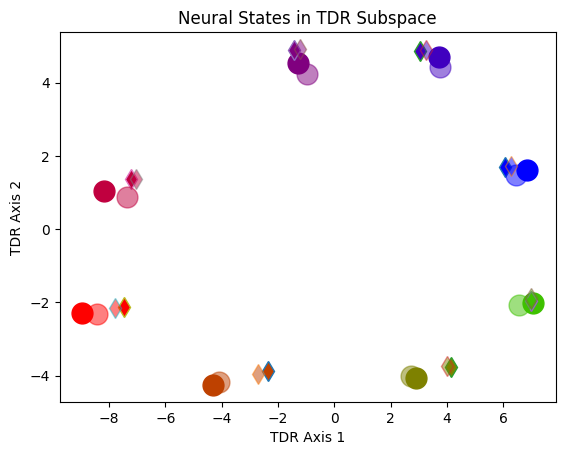

In [26]:
angle_set = np.deg2rad(np.arange(0, 360, 45))  # 8 directions
#angle_set = np.deg2rad(np.array([0,45,60,75,90,105,120,135,180,225,315]))
color_list = [plt.cm.brg(cond / (2 * np.pi)) for cond in angle_set]
n_cond = len(angle_set)

# Create a scatter plot
plt.figure()
for i in range(n_cond):
    plt.plot(data_p[0][i,0], data_p[0][i,1],'.', markersize=30, color=color_list[i])
    plt.plot(data_p[1][i,0], data_p[1][i,1],'d', markersize=10, markerfacecolor=color_list[i])
    plt.plot(data_p[2][i,0], data_p[2][i,1],'.', markersize=30, color=color_list[i],alpha=0.5)
    plt.plot(data_p[3][i,0], data_p[3][i,1],'d', markersize=10, markerfacecolor=color_list[i],alpha=0.5)
    #plt.plot(data_p[4][i,0], data_p[4][i,1],'>', markersize=10, markerfacecolor=color_list[i],alpha=0.5)

plt.xlabel('TDR Axis 1')
plt.ylabel('TDR Axis 2')
plt.title('Neural States in TDR Subspace')

plt.show()

# Better visualization

In [31]:
label = []

for i in range(len(labels)):
    for j in range(i + 1, len(labels)):
        pair = f'({labels[i]},{labels[j]})'
        label.append(pair)




In [32]:
label

['(NF1,FF1)', '(NF1,NF2)', '(NF1,FF2)', '(FF1,NF2)', '(FF1,FF2)', '(NF2,FF2)']

T-statistic: 2.1676611874338048
P-value: 0.043093868171310716


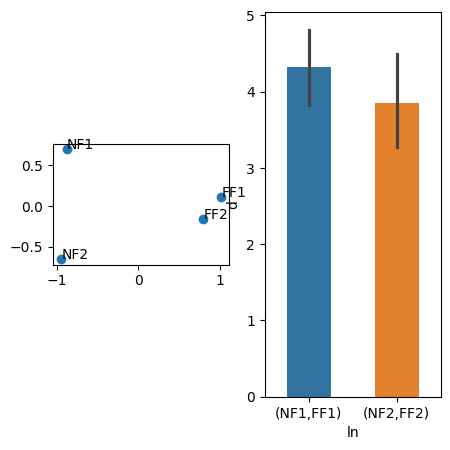

In [33]:
import PcmPy as pcm
labels = ['NF1','FF1','NF2','FF2']

rdm_avg = np.mean(np.stack(rdms,axis=0),axis=0)
rdm_m = squareform(rdm_avg)

n_cond = rdm_m.shape[0]

H = np.eye(n_cond) - np.ones((n_cond,n_cond))/n_cond
G = -0.5*H@rdm_m@H

# np.sum(pcm.G_to_dist(G)-rdm_m) # sanity check
W,Glam = pcm.classical_mds(G)

fig,ax = plt.subplots(1,2,figsize=(5,5))


ax[0].scatter(W[:,0],W[:,1])
ax[0].set_aspect('equal')

for i, label in enumerate(labels):
    ax[0].annotate(label, (W[i,0],W[i,1]))


# bar plot
select = [0,5]
#select = [0,7,8]


label = []

for i in range(len(labels)):
    for j in range(i + 1, len(labels)):
        pair = f'({labels[i]},{labels[j]})'
        label.append(pair)

L = pd.DataFrame()

for i in range(len(rdms)):
    for j in select:
        d = {'m':[i],'ln':[label[j]],'d':[rdms[i][j]]}
        L = pd.concat([L,pd.DataFrame(d)],ignore_index=True)

ax[1] = sb.barplot(x='ln',y='d',data=L,hue='ln',width=0.5)

sample1 = L.d[L.ln == '(NF1,FF1)'].to_numpy()
sample2 = L.d[L.ln == '(NF2,FF2)'].to_numpy()
sample3 = L.d[L.ln == '(NF2,FF2-)'].to_numpy()

# Perform paired t-test
t_statistic, p_value = stats.ttest_rel(sample1, sample2)

print("T-statistic:", t_statistic)
print("P-value:", p_value)

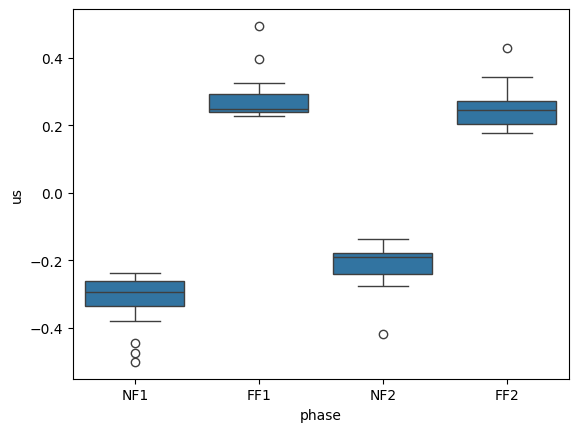

In [28]:
# Assuming T is your DataFrame
sb.boxplot(x='phase', y='us', data=T)
plt.show()

In [34]:
sample1 = T.us[T.phase == 'NF1'].to_numpy()
sample2 = T.us[T.phase == 'FF1'].to_numpy()
sample3 = T.us[T.phase == 'NF2'].to_numpy()
sample4 = T.us[T.phase == 'FF2'].to_numpy()
sample5 = T.us[T.phase == 'FF2-'].to_numpy()


# Perform paired t-test
t_statistic, p_value = stats.ttest_rel(sample2, sample4)

print("T-statistic:", t_statistic)
print("P-value:", p_value)

T-statistic: 2.8672690725065872
P-value: 0.009862184953323215
